# Tensorflow option

> Finbar Giusti

In this notebook, I will test using a transformer network to predict these seismic events.

In [1]:
%%capture
# required libraries

%pip install numpy pandas tensorflow scikit-learn seaborn matplotlib obspy keras 

import pandas as pd
import numpy as np
import seaborn as sns
from obspy import read
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
import matplotlib.pyplot as plt
from obspy.signal.invsim import cosine_taper
from scipy.signal import welch
from obspy.signal.freqattributes import spectrum

In [2]:
# lets collect the data from the catalog (this 

catalog = pd.read_csv('data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv')

training_data = {}

for index, row in catalog.iterrows():
    training_data[row.evid] = {
        'data': read('data/lunar/training/data/S12_GradeA/' + row.filename + '.mseed'),
        'rel_time': row['time_rel(sec)'],
        'type': row['mq_type']
    }

## Theory
I would like to use a transformer network to make the binary prediction of whether or not a given window contains the beginning of a seismic event. A transformer network is used as some parts of the signal are more important than others in the prediction of these events.

In [3]:
# first let's peek at a sample of the seismic events, to determine how large we should make the windows.

events = training_data.keys()

WINDOW = 10000 # 10,000 secs for training window


In [4]:
nfft = 1024  # Number of points in FFT
width = 3 

def convert_to_low_res(tr):
    minfreq = 0.5
    maxfreq = 1.0
    
    # Going to create a separate trace for the filter data
    trace = tr.copy()
    tr.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
    
    # Step 2: Define your parameters
    fs = trace.stats.sampling_rate  # Sampling frequency
    n_seconds = int(trace.stats.npts / fs)  # Total number of seconds
    n_bins = 10  # Number of frequency bands
    freq_bins = np.linspace(0, fs / 2, n_bins + 1)  # Define frequency bands
    amplitudes = np.zeros((n_seconds, n_bins))  # Prepare an array to store amplitudes
    
    # Step 3: Process the data for each second
    for i in range(int(n_seconds/width)):
        start = i*width
        segment = trace.data[int(start * fs):int((start + width) * fs)]
        
        # # Apply a taper to minimize edge effects
        # taper = cosine_taper(len(segment), 0.1)  # 10% taper
        # segment *= taper
    
        # Compute the PSD using Welch's method
        f, Pxx = welch(segment, fs, nperseg=fs * width, nfft=nfft, scaling='density')
    
        # Step 4: Aggregate the data into frequency bins
        for i in range(n_bins):
            mask = (f >= freq_bins[i]) & (f < freq_bins[i + 1])
            amplitudes[start, i] = np.sqrt(np.sum(Pxx[mask]))

    return amplitudes


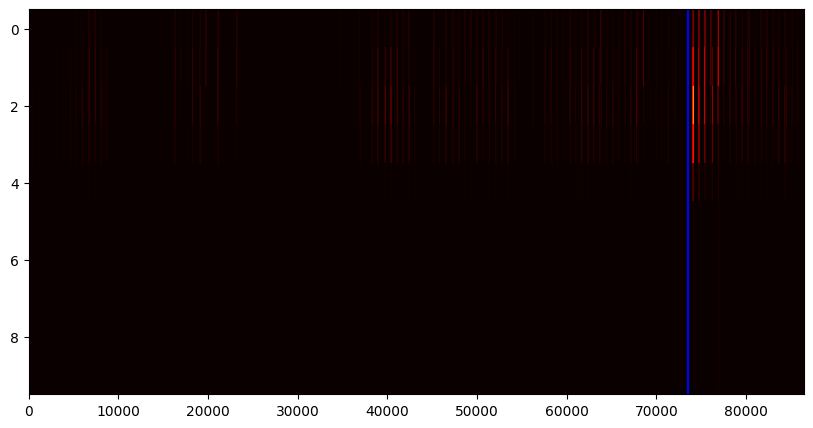

In [5]:
# lets see how this transforms the data.
sample = training_data[next(iter(events))]
example = convert_to_low_res(sample['data'][0])
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(example.T, cmap='hot', interpolation='nearest')
ax.set_aspect('auto')
ax.axvline(x = sample['rel_time'], color='blue',label='Rel. Arrival')
plt.show()

In [6]:
# lets transform these datapoints (this may take some time)

# for event in events:
#     training_data[event]['data_low_res'] = convert_to_low_res(training_data[event]['data'][0])

In [7]:
# # reflect, to save time
# for event in events:
#     np.savetxt('processed_data/low_res_' + event, training_data[event]['data_low_res'])

In [8]:
# pull from reflextion

for event in events:
    training_data[event]['data_low_res'] = np.loadtxt('processed_data/low_res_' + event)
    

In [9]:
# for event in events:
#     fig, ax = plt.subplots(figsize=(10, 5))
#     ax.imshow(training_data[event]['data_low_res'].T, cmap='hot', interpolation='nearest')
#     ax.set_aspect('auto')
#     ax.axvline(x = training_data[event]['rel_time'], color='blue',label='Rel. Arrival')
#     plt.show()

In [10]:
# now, we can create a set of samples, based on windowed chops of each spectrum.

In [11]:
CONTEXT_SIZE = 10000
OVERLAP = 2000

def generate_samples(event):
    X = []
    Y = []
    
    data = event['data_low_res']
    event_time = event['rel_time']
    start = 0
    while start < len(data) - CONTEXT_SIZE:
        X.append(data[start:start+CONTEXT_SIZE])
        Y.append(
            1 if start <= event_time and start+CONTEXT_SIZE > event_time else 0
        )
        start += int(CONTEXT_SIZE - OVERLAP)

    return X,Y


    

In [17]:
X = []
Y = []

for event in events:
    event_X, event_Y = generate_samples(training_data[event])
    X = X + event_X
    Y = Y + event_Y

X = np.array([normalize(x) for x in X])
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=69)

In [ ]:
from BinaryTransformClassify import BinaryTransformClassifier 

X_train = X_train.reshape(len(X_train), 10, 10000, 1)

btc = BinaryTransformClassifier(X_train[0].shape)

history = btc.train(50, X_train, Y_train, batch_size=20)



Epoch 1/50
10/28 ━━━━━━━━━━━━━━━━━━━━ 5:43 19s/step - loss: 0.3566 - sparse_categorical_accuracy: 0.9060

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
btc.evaluate(X_test, Y_test)

In [ ]:
np.unique(Y_test, return_counts=True)